The model is based on Unet++ with EfficientNet Encoder [Kaggle kernel](https://www.kaggle.com/meaninglesslives/unet-plus-plus-with-efficientnet-encoder) by Siddharta with several improvements.

Unet++ introduces intermediate layers to skip connections of U-Net, which naturally form multiple new up-sampling paths from different depths, ensembling U-Nets of various receptive fields. This results in far better performance than traditional Unet. 
For more details please refer to ["UNet++: A Nested U-Net Architecture for Medical Image Segmentation"]( https://arxiv.org/abs/1807.10165)

- The model is upscaled from 256x256 to 512x512 via progressive training
- Gradient accumulation is added
- 5-fold ensemble

Other model features:
- Image augmentation 
- Cosine annealing for learning rate
- Stochastic Weight Averaging
- Horizontal flip TTA

# Loading Libraries

In [5]:
#!pip install -U efficientnet==0.0.4
import numpy as np
import pandas as pd
import gc
import keras

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split,StratifiedKFold

from skimage.transform import resize
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import  ModelCheckpoint
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.losses import binary_crossentropy
import keras.callbacks as callbacks
from keras.callbacks import Callback
from keras.applications.xception import Xception
from keras.layers import multiply

from keras.optimizers import Optimizer, Adam

from keras import optimizers
from keras.legacy import interfaces
from keras.utils.generic_utils import get_custom_objects

from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.regularizers import l2
from keras.layers.core import Dense, Lambda
from keras.layers.merge import concatenate, add
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

import cv2
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
    IAAAdditiveGaussianNoise,GaussNoise,OpticalDistortion,RandomSizedCrop
)

import glob
import shutil
import os
import random
from PIL import Image

seed = 13
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.set_random_seed(seed)
    
%matplotlib inline

In [ ]:
INPUT_DIR='../input/512_s2'
OUTPUT_DIR='../output/f5'

model_input_weights='../output/f5/keras_s2_512_f5.model'
model_output_file=OUTPUT_DIR+'/keras_s2_512-2_f5.model'
model_output_swa=OUTPUT_DIR+'/keras_swa_s2_512-2_f5.model'

MODEL_LR=1e-4
img_size = 512 #256
epochs = 16
batch_size = 4
n_ga_steps = 4

# Loading Training Set Data

## Pneumothorax as percentage of mask

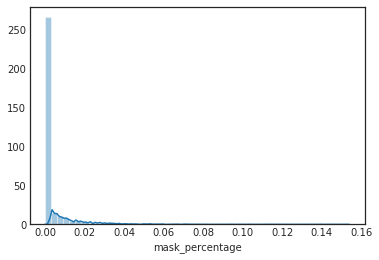

In [8]:
all_mask_fn = glob.glob(INPUT_DIR+'/masks/*')
mask_df = pd.DataFrame()
mask_df['file_names'] = all_mask_fn
mask_df['mask_percentage'] = 0
mask_df.set_index('file_names',inplace=True)
for fn in all_mask_fn:
    mask_df.loc[fn,'mask_percentage'] = np.array(Image.open(fn)).sum()/(img_size*img_size*255) #255 is bcz img range is 255
    
mask_df.reset_index(inplace=True)
sns.distplot(mask_df.mask_percentage)
mask_df['labels'] = 0
mask_df.loc[mask_df.mask_percentage>0,'labels'] = 1

In [9]:
all_train_fn = glob.glob(INPUT_DIR+'/train/*')
total_samples = len(all_train_fn)
idx = np.arange(total_samples)
train_fn,val_fn = train_test_split(all_train_fn,stratify=mask_df.labels,test_size=0.1,random_state=seed)

print('No. of train files:', len(train_fn))
print('No. of val files:', len(val_fn))

masks_train_fn = [fn.replace('/train','/masks') for fn in train_fn]    
masks_val_fn = [fn.replace('/train','/masks') for fn in val_fn]

No. of train files: 10842
No. of val files: 1205


In [10]:
# !mkdir ./keras_im_train
# train_dir = './keras_im_train'
# for full_fn in train_fn:
#     fn = full_fn.split('/')[-1]
#     shutil.copy(full_fn,os.path.join(train_dir,fn))
    
# !mkdir ./keras_mask_train
# train_dir = './keras_mask_train'
# for full_fn in masks_train_fn:
#     fn = full_fn.split('/')[-1]
#     shutil.copy(full_fn,os.path.join(train_dir,fn))
    
# !mkdir ./keras_im_val
# train_dir = './keras_im_val'
# for full_fn in val_fn:
#     fn = full_fn.split('/')[-1]
#     shutil.copy(full_fn,os.path.join(train_dir,fn))
    
# !mkdir ./keras_mask_val
# train_dir = './keras_mask_val'
# for full_fn in masks_val_fn:
#     fn = full_fn.split('/')[-1]
#     shutil.copy(full_fn,os.path.join(train_dir,fn))

In [11]:
train_im_path,train_mask_path = './keras_im_train','./keras_mask_train'
h,w = img_size,img_size #256,256,16

val_im_path,val_mask_path = './keras_im_val','./keras_mask_val'

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, train_im_path=train_im_path,train_mask_path=train_mask_path,
                 augmentations=None, batch_size=batch_size,img_size=img_size, n_channels=3, shuffle=True): #256
        'Initialization'
        self.batch_size = batch_size
        self.train_im_paths = glob.glob(train_im_path+'/*')
        
        self.train_im_path = train_im_path
        self.train_mask_path = train_mask_path

        self.img_size = img_size
        
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.augment = augmentations
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.train_im_paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:min((index+1)*self.batch_size,len(self.train_im_paths))]

        # Find list of IDs
        list_IDs_im = [self.train_im_paths[k] for k in indexes]

        # Generate data
        X, y = self.data_generation(list_IDs_im)

        if self.augment is None:
            return X,np.array(y)/255
        else:            
            im,mask = [],[]   
            for x,y in zip(X,y):
                augmented = self.augment(image=x, mask=y)
                im.append(augmented['image'])
                mask.append(augmented['mask'])
            return np.array(im),np.array(mask)/255

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.train_im_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def data_generation(self, list_IDs_im):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((len(list_IDs_im),self.img_size,self.img_size, self.n_channels))
        y = np.empty((len(list_IDs_im),self.img_size,self.img_size, 1))

        # Generate data
        for i, im_path in enumerate(list_IDs_im):
            
            im = np.array(Image.open(im_path))
            mask_path = im_path.replace(self.train_im_path,self.train_mask_path)
            
            mask = np.array(Image.open(mask_path))
            
            
            if len(im.shape)==2:
                im = np.repeat(im[...,None],3,2)

#             # Resize sample
            X[i,] = cv2.resize(im,(self.img_size,self.img_size))

            # Store class
            y[i,] = cv2.resize(mask,(self.img_size,self.img_size))[..., np.newaxis]
            y[y>0] = 255

        return np.uint8(X),np.uint8(y)

## Augmentations

In [12]:
AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    OneOf([
        RandomContrast(),
        RandomGamma(),
        RandomBrightness(),
         ], p=0.3),
    OneOf([
        ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        GridDistortion(),
        OpticalDistortion(distort_limit=2, shift_limit=0.5),
        ], p=0.3),
    RandomSizedCrop(min_max_height=(img_size-int(img_size/256)*100, img_size), height=h, width=w,p=0.25), #(156, 256)
    ToFloat(max_value=1)
],p=1)


AUGMENTATIONS_TEST = Compose([
    ToFloat(max_value=1)
],p=1)

# Train Set Images with Masks

Text(0.5, 0.98, 'Chest X-rays, Red: Pneumothorax.')

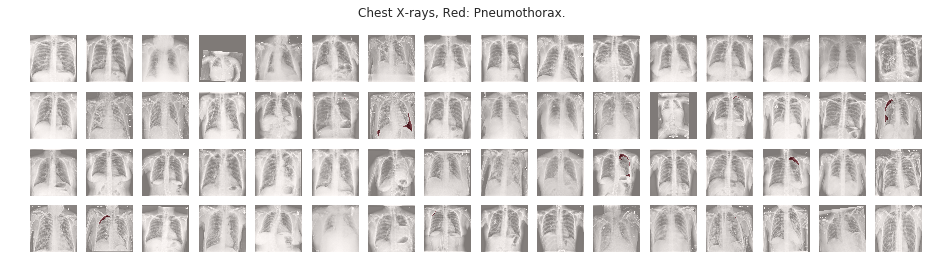

In [13]:
a = DataGenerator(batch_size=64,shuffle=False)
images,masks = a.__getitem__(0)
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

for i,(im, mask) in enumerate(zip(images,masks)):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im.squeeze(), cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.axis('off')
plt.suptitle("Chest X-rays, Red: Pneumothorax.")

# Images after Augmentations

Text(0.5, 0.98, 'Chest X-rays, Red: Pneumothorax.')

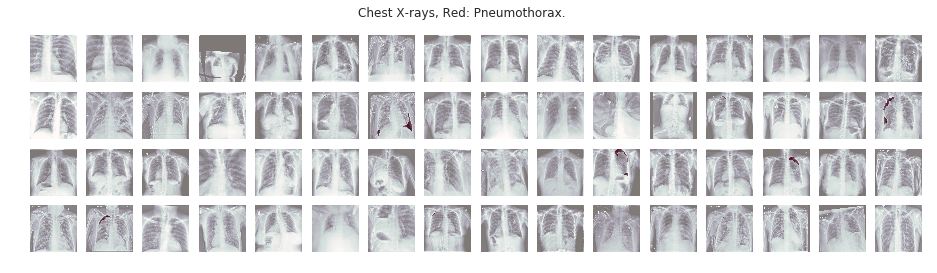

In [14]:
a = DataGenerator(batch_size=64,augmentations=AUGMENTATIONS_TRAIN,shuffle=False)
images,masks = a.__getitem__(0)
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

for i,(im, mask) in enumerate(zip(images,masks)):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im[:,:,0], cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.axis('off')
plt.suptitle("Chest X-rays, Red: Pneumothorax.")

# Calculating IOU

In [15]:
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)

# Defining Dice Loss

In [16]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

# Define Learning Rate Scheduler
using cosine annealing for learning rate

In [17]:
class SnapshotCallbackBuilder:
    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model'):

        callback_list = [
            callbacks.ModelCheckpoint(model_output_file,monitor='val_my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1),
            swa,
            callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule)
        ]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)

# Defining UEfficientNet Model

As mentioned above, this model uses pretrained EfficientNetB4 model as encoder. I use Residual blocks in the decoder part.

In [ ]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

In [19]:
from efficientnet import EfficientNetB4

def UEfficientNet(input_shape=(None, None, 3),dropout_rate=0.1):

    backbone = EfficientNetB4(weights='imagenet',
                            include_top=False,
                            input_shape=input_shape)
    input = backbone.input
    start_neurons = 8

    conv4 = backbone.layers[342].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    deconv4_up1 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4)
    deconv4_up2 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up1)
    deconv4_up3 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up2)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4) 
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
#     uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)  #conv1_2
    
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3_up1 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3)
    deconv3_up2 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3_up1)
    conv3 = backbone.layers[154].output
    uconv3 = concatenate([deconv3,deconv4_up1, conv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
#     uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    deconv2_up1 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(deconv2)
    conv2 = backbone.layers[92].output
    uconv2 = concatenate([deconv2,deconv3_up1,deconv4_up2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
#     uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[30].output
    uconv1 = concatenate([deconv1,deconv2_up1,deconv3_up2,deconv4_up3, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
#     uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
#     uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)
    model.name = 'u-xception'

    return model

In [21]:
K.clear_session()
model = UEfficientNet(input_shape=(img_size,img_size,3),dropout_rate=0.5)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# Graduate Accumulation

In [ ]:
class AccumOptimizer(Optimizer):
    """Inheriting Optimizer class, wrapping the original optimizer
    to achieve a new corresponding optimizer of gradient accumulation.
    # Arguments
        optimizer: an instance of keras optimizer (supporting
                    all keras optimizers currently available);
        steps_per_update: the steps of gradient accumulation
    # Returns
        a new keras optimizer.
    """

    def __init__(self, optimizer, steps_per_update=1, **kwargs):
        super(AccumOptimizer, self).__init__(**kwargs)
        self.optimizer = optimizer
        with K.name_scope(self.__class__.__name__):
            self.steps_per_update = steps_per_update
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.cond = K.equal(self.iterations % self.steps_per_update, 0)
            self.lr = self.optimizer.lr
            self.optimizer.lr = K.switch(self.cond, self.optimizer.lr, 0.)
            for attr in ['momentum', 'rho', 'beta_1', 'beta_2']:
                if hasattr(self.optimizer, attr):
                    value = getattr(self.optimizer, attr)
                    setattr(self, attr, value)
                    setattr(self.optimizer, attr, K.switch(self.cond, value, 1 - 1e-7))
            for attr in self.optimizer.get_config():
                if not hasattr(self, attr):
                    value = getattr(self.optimizer, attr)
                    setattr(self, attr, value)
            # Cover the original get_gradients method with accumulative gradients.
            def get_gradients(loss, params):
                return [ag / self.steps_per_update for ag in self.accum_grads]
            self.optimizer.get_gradients = get_gradients            
    def get_updates(self, loss, params):
        self.updates = [
            K.update_add(self.iterations, 1),
            K.update_add(self.optimizer.iterations, K.cast(self.cond, 'int64')),
        ]
        # gradient accumulation
        self.accum_grads = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        grads = self.get_gradients(loss, params)
        for g, ag in zip(grads, self.accum_grads):
            self.updates.append(K.update(ag, K.switch(self.cond, ag * 0, ag + g)))
        # inheriting updates of original optimizer
        self.updates.extend(self.optimizer.get_updates(loss, params)[1:])
        self.weights.extend(self.optimizer.weights)
        return self.updates
    def get_config(self):
        iterations = K.eval(self.iterations)
        K.set_value(self.iterations, 0)
        config = self.optimizer.get_config()
        K.set_value(self.iterations, iterations)
        return config

# Stochastic Weight Averaging
I have found SWA to give better results. Please check out the paper for more info.

In [22]:
class SWA(keras.callbacks.Callback):
    
    def __init__(self, filepath, swa_epoch):
        super(SWA, self).__init__()
        self.filepath = filepath
        self.swa_epoch = swa_epoch 
    
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        print('Stochastic weight averaging selected for last {} epochs.'
              .format(self.nb_epoch - self.swa_epoch))
        
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
            
        elif epoch > self.swa_epoch:    
            for i in range(len(self.swa_weights)):
                self.swa_weights[i] = (self.swa_weights[i] * 
                    (epoch - self.swa_epoch) + self.model.get_weights()[i])/((epoch - self.swa_epoch)  + 1)  

        else:
            pass
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)
        print('Final model parameters set to stochastic weight average.')
        self.model.save_weights(self.filepath)
        print('Final stochastic averaged weights saved to file.')

# Training

In [ ]:
opt = AccumOptimizer(Adam(), steps_per_update = n_ga_steps)
model.compile(loss=bce_dice_loss, optimizer=opt, metrics=[my_iou_metric])
model.load_weights(model_input_weights)

In [25]:
snapshot = SnapshotCallbackBuilder(nb_epochs=epochs,nb_snapshots=1,init_lr=MODEL_LR)

swa = SWA(model_output_swa,epochs-3)
valid_im_path,valid_mask_path = './keras_im_val','./keras_mask_val'
# Generators
training_generator = DataGenerator(augmentations=AUGMENTATIONS_TRAIN,img_size=img_size)
validation_generator = DataGenerator(train_im_path = valid_im_path ,
                                     train_mask_path=valid_mask_path,augmentations=AUGMENTATIONS_TEST,
                                     img_size=img_size)

history = model.fit_generator(generator=training_generator,
                            validation_data=validation_generator,                            
                            use_multiprocessing=False,
                            epochs=epochs,verbose=2,
                            callbacks=snapshot.get_callbacks())

Instructions for updating:
Use tf.cast instead.
Stochastic weight averaging selected for last 3 epochs.
Epoch 1/16


/home/akuritsyn/anaconda3/envs/fastai-tf/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in greater


 - 1717s - loss: 0.6963 - my_iou_metric: 0.7415 - val_loss: 0.5417 - val_my_iou_metric: 0.7232

Epoch 00001: val_my_iou_metric improved from -inf to 0.72315, saving model to ./keras_s2_512-2_f5.model
Epoch 2/16
 - 1680s - loss: 0.6961 - my_iou_metric: 0.7308 - val_loss: 0.5267 - val_my_iou_metric: 0.7039

Epoch 00002: val_my_iou_metric did not improve from 0.72315
Epoch 3/16
 - 1680s - loss: 0.6851 - my_iou_metric: 0.7119 - val_loss: 0.4822 - val_my_iou_metric: 0.7236

Epoch 00003: val_my_iou_metric improved from 0.72315 to 0.72357, saving model to ./keras_s2_512-2_f5.model
Epoch 4/16
 - 1682s - loss: 0.6837 - my_iou_metric: 0.7331 - val_loss: 0.4641 - val_my_iou_metric: 0.7500

Epoch 00004: val_my_iou_metric improved from 0.72357 to 0.74996, saving model to ./keras_s2_512-2_f5.model
Epoch 5/16
 - 1682s - loss: 0.6819 - my_iou_metric: 0.7609 - val_loss: 0.4730 - val_my_iou_metric: 0.7234

Epoch 00005: val_my_iou_metric did not improve from 0.74996
Epoch 6/16
 - 1682s - loss: 0.6774 - m

0

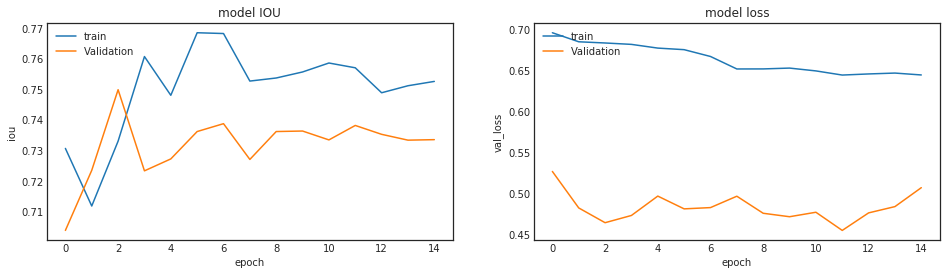

In [26]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(history.history['my_iou_metric'][1:])
plt.plot(history.history['val_my_iou_metric'][1:])
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')

plt.title('model IOU')

plt.subplot(1,2,2)
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.title('model loss')
gc.collect()